## Statistical analysis of the wind

In [1]:
import sys
print("Python version: {}".format(sys.version))

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.stats as st
import pandas as pd

path = "../data/"
prepared_path = path+"prepared/"

#### Importing wind data

In [3]:
df_wind = pd.read_pickle(prepared_path+"df_wind.pkl")
df_wind.head(3)

,date_time,AL [st],W [m/s]
0,2008-01-01 00:00:00,151.83,2.50
1,2008-01-01 01:00:00,151.83,2.50
2,2008-01-01 02:00:00,155.17,2.78


#### Simple statistical description of wind velocity values

In [4]:
df_wind[["AL [st]", "W [m/s]"]].describe()

,AL [st],W [m/s]
count,86856.000000,86856.000000
mean,183.243625,5.080343
std,89.141078,3.127175
min,0.000000,0.000000
25%,121.670000,2.750000
50%,180.670000,4.580000
75%,247.500000,7.050000
max,359.000000,35.270000


#### Wind velocity histogram
Some exact bins will be used

In [5]:
ws_bins = np.linspace(0,35.3,32)

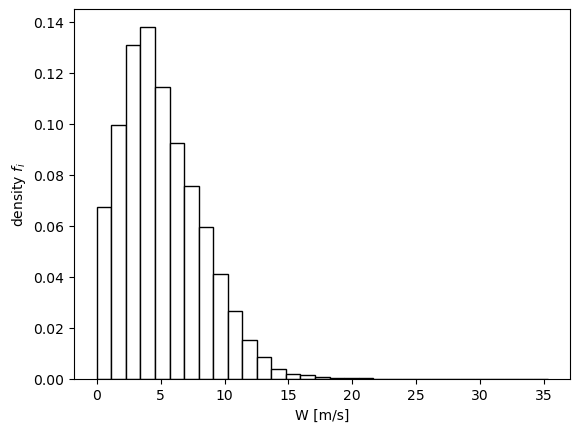

In [6]:
df = df_wind
plt.hist(df["W [m/s]"],density=True,bins=ws_bins, edgecolor = "black", color = "white")
plt.xlabel("W [m/s]")
plt.ylabel("density $f_i$")
pass

### Histogram comparison with [Weibull Distribution](https://en.wikipedia.org/wiki/Weibull_distribution)

#### MLE estimation of the Weibull distribution parameters

In [7]:
from scipy.optimize import newton

def k_eq(x,k):
    return np.sum((x**k)*np.log(x))/np.sum(x**k) - 1./k - np.mean(np.log(x))

ws = df.loc[(df["W [m/s]"].isna()==False) & (df["W [m/s]"])>0,"W [m/s]"].to_numpy()

ek = newton(lambda k:k_eq(ws,k), 1)
lb = np.exp(np.log(np.mean(ws**ek))/ek)

print("estimated parameters")
(ek,lb)

estimated parameters


(1.7219969131346557, 5.802566499606295)

#### Weibull distribution definition

In [8]:
class weibull_dist(st.rv_continuous): # dziedziczenie po klasie rv_continuous
    "Weibull distribution"
    
    def __init__(self,k:float,lb:float): 
        super().__init__()
        self.shape = k            
        self.scale = lb

    def _pdf(self, x:float)->float: # density function overload _pdf 
        return self.shape/self.scale * (x/self.scale)**(self.shape-1) * np.exp(-(x/self.scale)**self.shape)

    def _cdf(self, x:float)->float: # cumulative distribution function overload _cdf 
        return 1. - np.exp(-(x/self.scale)**self.shape)    
wbd = weibull_dist(ek,lb) # instatiate weibull dist

#### Histogram vs. Weibull distribution

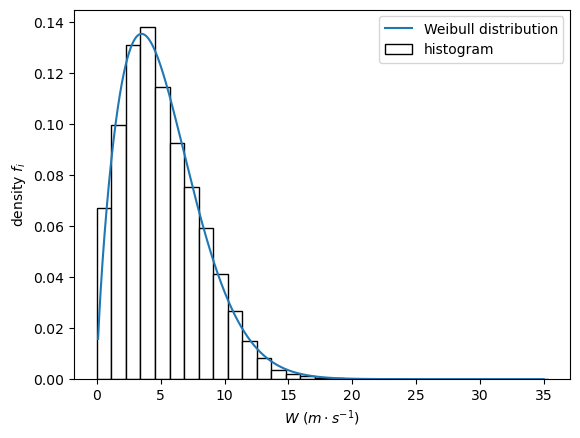

In [9]:
t = np.arange(0.1,35,0.01)
plt.hist(df["W [m/s]"],density=True,bins=ws_bins, edgecolor = "black", color = "white")
#plt.plot(t,np.fromiter(map(lambda x: wbd.pdf(x),t),dtype=float))
plt.plot(t,wbd.pdf(t))
plt.xlabel("$W\ (m \cdot s^{-1})$")
plt.ylabel("density $f_i$")
plt.legend(["Weibull distribution","histogram"])
pass
#plt.savefig('fig9a.svg')

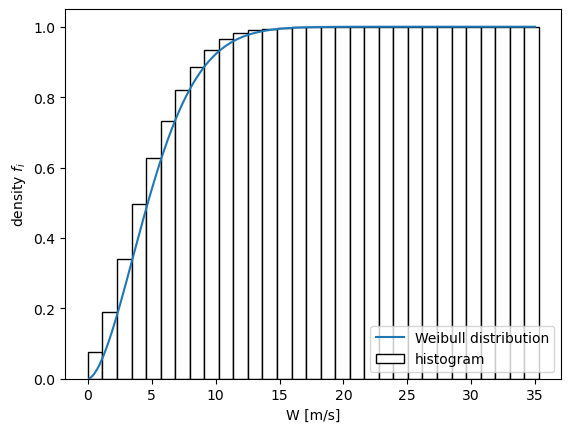

In [10]:
t = np.arange(0.1,35,0.01)
plt.hist(df["W [m/s]"],density=True,bins=ws_bins, cumulative=True, edgecolor = "black", color = "white")
#plt.plot(t,np.fromiter(map(lambda x: wbd.pdf(x),t),dtype=float))
plt.plot(t,wbd.cdf(t))
plt.xlabel("W [m/s]")
plt.ylabel("density $f_i$")
plt.legend(["Weibull distribution","histogram"])
pass

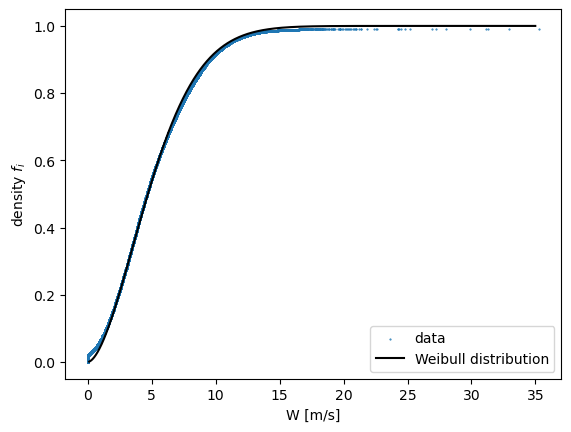

In [11]:
w = np.sort(df["W [m/s]"].to_numpy())
t1 = np.arange(len(w))/len(w)
plt.scatter(w,t1,s=0.25)

t = np.arange(0.1,35,0.01)
plt.plot(t,wbd.cdf(t),"black")

plt.xlabel("W [m/s]")
plt.ylabel("density $f_i$")
plt.legend(["data","Weibull distribution"])
pass

In [12]:
st.kstest(ws,wbd.cdf)

KstestResult(statistic=0.009115993851654847, pvalue=1.4162836451945543e-06, statistic_location=7.27, statistic_sign=-1)

### Windrose

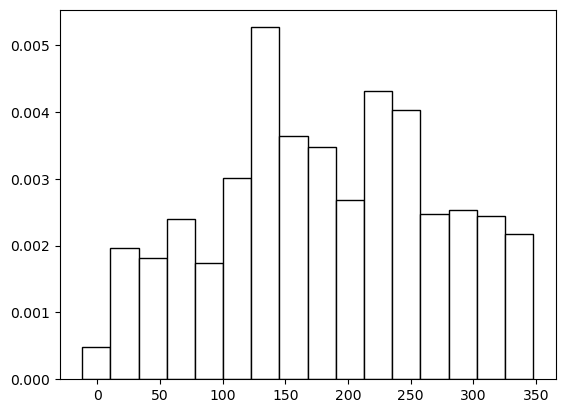

In [13]:
_ = plt.hist(df["AL [st]"],density=True,bins=np.arange(-12.25,370,22.5), edgecolor = "black", color = "white")

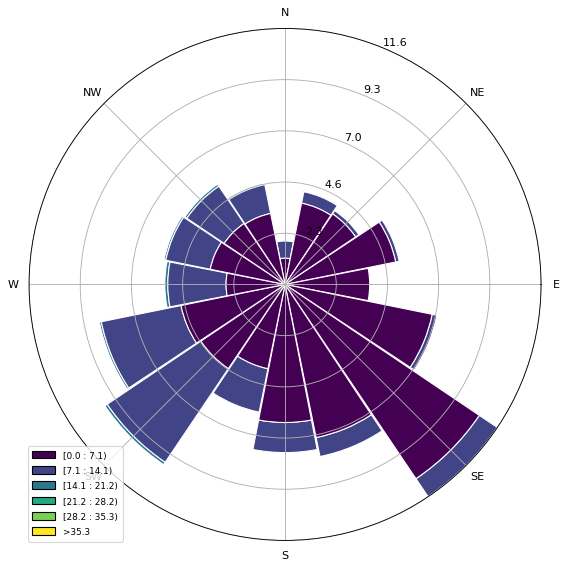

In [14]:
ax = WindroseAxes.from_ax()
ax.bar(df["AL [st]"],df["W [m/s]"], normed=True, opening=0.98, edgecolor='white')
#ax.set_xticks(np.pi/180. * np.linspace(0,  360, 8, endpoint=False))
ax.set_xticklabels(["E","NE","N","NW","W","SW","S","SE"])
ax.set_legend()
#plt.savefig('fig9b.svg')

<BarContainer object of 16 artists>

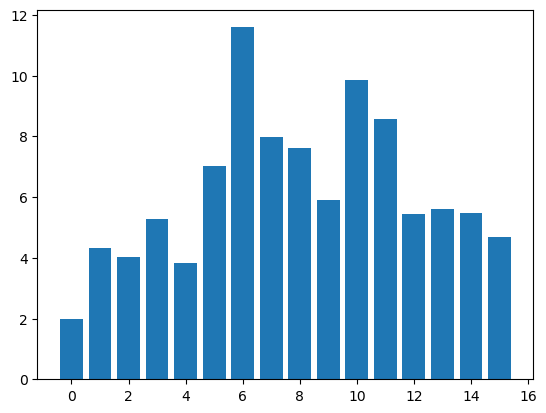

In [15]:
table = ax._info['table']
wd_freq = np.sum(table, axis=0)

direction = ax._info['dir']
wd_freq = np.sum(table, axis=0)
plt.bar(np.arange(16), wd_freq, align='center')

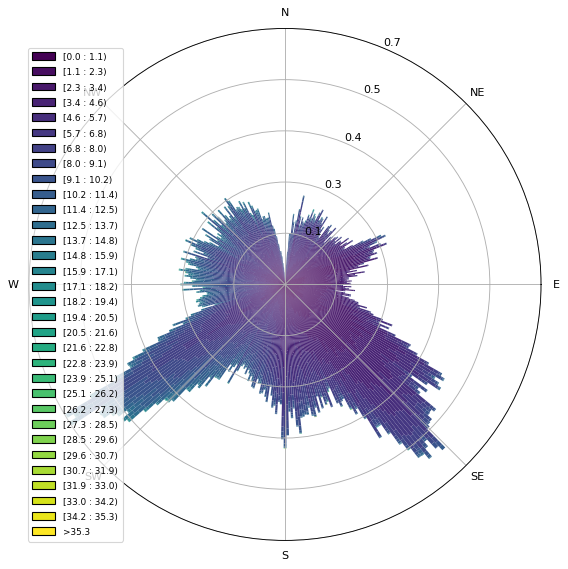

In [16]:
ax = WindroseAxes.from_ax()
ax.bar(df["AL [st]"],df["W [m/s]"], normed=True, opening=1.0,nsector=360,bins=ws_bins)
ax.set_xticklabels(["E","NE","N","NW","W","SW","S","SE"])
ax.set_legend()

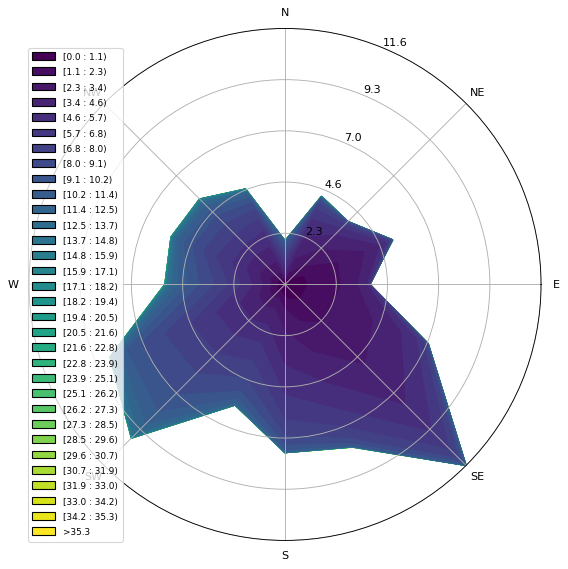

In [17]:
ax = WindroseAxes.from_ax()
ax.contourf(df["AL [st]"],df["W [m/s]"],normed=True, bins=ws_bins,nsector=16)
ax.set_xticklabels(["E","NE","N","NW","W","SW","S","SE"])
ax.set_legend()

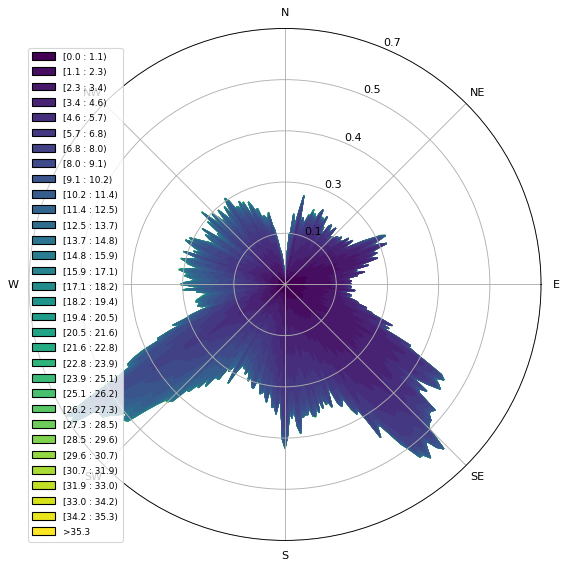

In [18]:
ax = WindroseAxes.from_ax()
ax.contourf(df["AL [st]"],df["W [m/s]"],normed=True, bins=ws_bins,nsector=360)
ax.set_xticklabels(["E","NE","N","NW","W","SW","S","SE"])
ax.set_legend()

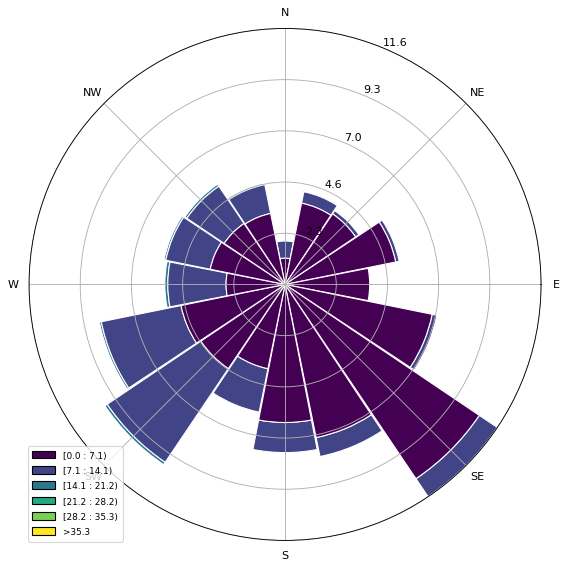

In [19]:
ax = WindroseAxes.from_ax()
ax.bar(df_wind["AL [st]"],df_wind["W [m/s]"], normed=True, opening=0.98, edgecolor='white')
#ax.set_xticks(np.pi/180. * np.linspace(0,  360, 8, endpoint=False))
ax.set_xticklabels(["E","NE","N","NW","W","SW","S","SE"])
ax.set_legend()
pass

#### Frequency analysis of the wind parameters

In [20]:
df = df_wind
cond = df["AL [st]"]>348.75
df["AL1"] = df["AL [st]"]
df.loc[cond,"AL1"] = 1
df.head(3)

,date_time,AL [st],W [m/s],AL1
0,2008-01-01 00:00:00,151.83,2.50,151.83
1,2008-01-01 01:00:00,151.83,2.50,151.83
2,2008-01-01 02:00:00,155.17,2.78,155.17


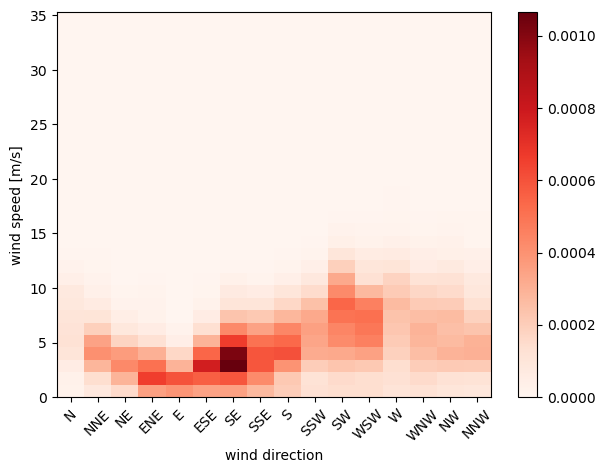

In [21]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 100 #

ws_bins = np.linspace(0,35.3,32)
AL_bins = np.linspace(0,  360, 17, endpoint=True) - 22.5/2

directions = ["N","NNE","NE","ENE","E","ESE","SE","SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
ax = plt.axes()
plt.hist2d(df["AL1"],df["W [m/s]"],bins=[AL_bins,ws_bins],density=True,cmap=plt.cm.Reds)

xt = np.linspace(0,  360, 16, endpoint=False)
ax.set_xticks(xt)
ax.set_xticklabels(directions)
plt.colorbar()
plt.xticks(rotation=45)
plt.xlabel("wind direction")
plt.ylabel("wind speed [m/s]")
pass

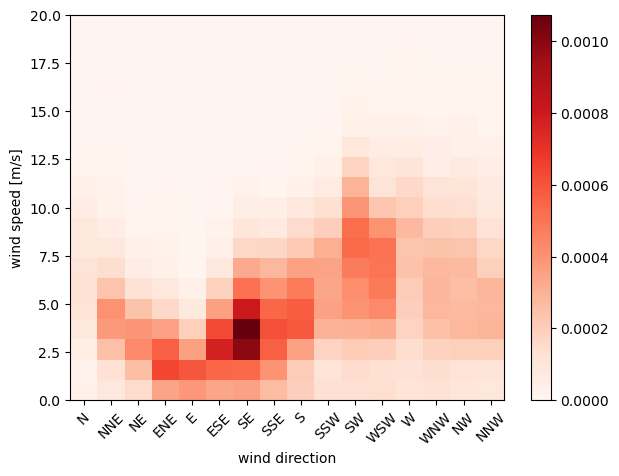

In [22]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 100 #

ws_bins = np.linspace(0,20,20)
AL_bins = np.linspace(0,  360, 17, endpoint=True) - 22.5/2

directions = ["N","NNE","NE","ENE","E","ESE","SE","SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]
ax = plt.axes()
plt.hist2d(df["AL1"],df["W [m/s]"],bins=[AL_bins,ws_bins],density=True,cmap=plt.cm.Reds)

xt = np.linspace(0,  360, 16, endpoint=False)
ax.set_xticks(xt)
ax.set_xticklabels(directions)
plt.colorbar()
plt.xticks(rotation=45)
plt.xlabel("wind direction")
plt.ylabel("wind speed [m/s]")
pass

#### Wind parameters time series analysis

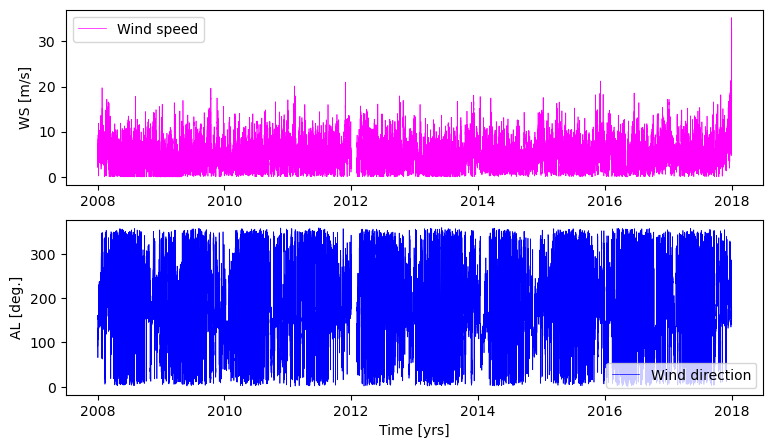

In [23]:
plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 100 #

ax1=plt.subplot(2, 1, 1)
ax1.plot(df_wind["date_time"],df_wind["W [m/s]"],color="magenta",linewidth=0.5)
plt.ylabel("WS [m/s]")
plt.legend(["Wind speed"])

#--------------------------------------------------------------------------
ax2=plt.subplot(2, 1, 2)
ax2.plot(df_wind["date_time"],df_wind["AL [st]"],color="blue",linewidth=0.5)
plt.ylabel("AL [deg.]")
plt.legend(["Wind direction"])

_ = plt.xlabel("Time [yrs]")

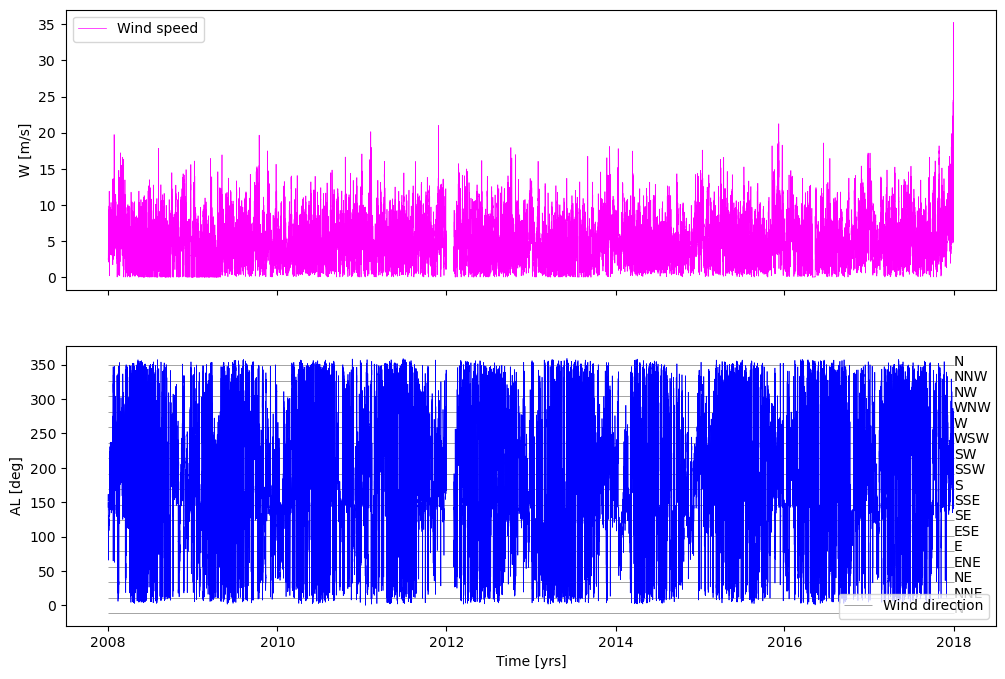

In [24]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 #

f, (ax2, ax3) = plt.subplots(2, 1, sharex=True)

ax2.plot(df_wind["date_time"],df_wind["W [m/s]"],color="magenta",linewidth=0.5)
ax2.set_ylabel("W [m/s]")
ax2.legend(["Wind speed"])

#--------------------------------------------------------------------------
AL_bins = np.linspace(0,  360, 17, endpoint=True) - 22.5/2
directions = ["N","NNE","NE","ENE","E","ESE","SE","SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]

date_min = df_wind["date_time"].to_numpy().min()
date_max = df_wind["date_time"].to_numpy().max()

ax3.hlines(AL_bins,date_min ,date_max,colors="gray",linewidth=0.5)

for i in range(len(directions)):
    ax3.text([date_max] ,AL_bins[i],directions[i])
ax3.text([date_max] ,AL_bins[-1],directions[0])


ax3.plot(df_wind["date_time"],df_wind["AL [st]"],color="blue",linewidth=0.5)
ax3.set_ylabel("AL [deg]")
ax3.legend(["Wind direction"])

_ = plt.xlabel("Time [yrs]")